Suppl. Fig. 13/14: FateID gene trends
---
In this notebook, we plot the smoothed expression trends for 8 genes and 4 lineages as uncovered by FateID.
In order to produce the plots visualizing the fate biases, please refer to [ML_2020-10-17_plot_fate_bias.ipynb](ML_2020-10-17_plot_fate_bias.ipynb).

# Preliminaries

## Dependency notebooks

1. [analysis_notebooks/MK_2020-10-17_extract_fate_bias.ipynb](analysis_notebooks/MK_2020-10-17_extract_fate_bias.ipynb)

## Import packages

In [1]:
# import standard packages
from typing import List, Optional
from copy import copy
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# import single-cell packages
import cellrank as cr
import scanpy as sc
import scvelo as scv

## Print package versions for reproducibility

In [2]:
cr.logging.print_versions()

cellrank==1.5.0+g65f1562 scanpy==1.8.1 anndata==0.7.6 numpy==1.20.3 numba==0.54.0 scipy==1.7.1 pandas==1.3.3 pygpcca==1.0.2 scikit-learn==0.24.2 statsmodels==0.13.0rc0 python-igraph==0.9.1 scvelo==0.2.4 pygam==0.8.0 matplotlib==3.4.3 seaborn==0.11.2


In [3]:
sys.path.insert(0, "../../..")  # this depends on the notebook depth and must be adapted per notebook

from paths import DATA_DIR, FIG_DIR

## Set global parameters

In [4]:
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80,
                               transparent=True, fontsize=20, color_map='viridis')

In [5]:
lineages = ['Alpha', 'Beta', 'Epsilon', 'Delta']
colors = ['#1f78b4', '#b2df8a', '#cab2d6', '#6a3d9a']
gene_colors = ['#b2df8a', '#b2df8a', '#1f78b4', '#1f78b4',
               '#cab2d6', '#cab2d6', '#6a3d9a', '#6a3d9a']
genes = ['Pax4', 'Pdx1', 'Arx', 'Peg10',
         'Irs4', 'Ghrl', 'Hhex', 'Cd24a']

root = DATA_DIR / "benchmarking" / "fateid"
root_fig = FIG_DIR / "fig_5_benchmarking" / "fateid"

# whether to write figures to file
save_figure = True

## Definte utility functions

In [6]:
def plot(genes: List[str], gene_colors: List[str], lineages: List[str], fname: Optional[str] = None) -> None:
    nrows = len(genes) + 1
    ncols = len(lineages) + 1
    
    fig, axess = plt.subplots(nrows=nrows, ncols=ncols,
                              dpi=180,
                              gridspec_kw=dict(hspace=0.05, wspace=0.05),
                              figsize=(ncols * 2.2 * 1.5, nrows * 2.2),
                              sharey='row', sharex='col')
    fig.tight_layout()

    for gene, gc, axes in zip(genes, gene_colors, axess):
        minn = min([dfs[ln][gene].values.min() for ln in lineages])
        maxx = max([dfs[ln][gene].values.max() for ln in lineages])
        yticks = np.array([minn, maxx])
        
        for i, (lineage, color, ax) in enumerate(zip(lineages, colors, axes)):
            ax.plot(dfs[lineage][gene].values, c=color, label=lineage)
            if i == 0:
                ax.set_ylabel(gene, color=gc)

            ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%0.0f"))
            ax.set_yticks(yticks)
            ax.set_xticks([])
            ax.margins(0.03)

    for gene, ax in zip(genes, axess[:, -1]):
        xy = adata.obsm['X_umap']
        expr = adata[:, gene].X.A.squeeze()
        
        ax.scatter(xy[:, 0], xy[:, 1], s=1, cmap='viridis',c = expr)
        for xsib in ax._shared_x_axes.get_siblings(ax):
            ax._shared_x_axes.remove(ax)
            
        for ysib in ax._shared_y_axes.get_siblings(ax):
            ax._shared_y_axes.remove(ax)
            
        ax.set_xticks([])
        ax.margins(0.03)
    
    xy = adata.obsm['X_umap']
    
    for lineage, root_name, ax in zip(lineages, root_ixs, axess[-1]):
        df = dfs[lineage]
        adata.obs['pt'] = np.nan
        adata.obs['pt'].loc[df.index] = df['pt']
        pt = adata.obs['pt'].values
        
        root_ix = np.where(adata.obs_names == root_name)[0][0]
        mask = ~np.isnan(pt)

        for xsib in ax._shared_x_axes.get_siblings(ax):
            ax._shared_x_axes.remove(ax)
            
        for ysib in ax._shared_y_axes.get_siblings(ax):
            ax._shared_y_axes.remove(ax)
           
        ax.scatter(xy[mask, 0], xy[mask, 1], s=1, c=pt[mask], cmap='viridis')
        ax.scatter(xy[~mask, 0], xy[~mask, 1], s=1, c='lightgrey')
        ax.scatter(xy[root_ix, 0], xy[root_ix, 1], s=60, c='yellow', edgecolor='black', linewidth=1.5)
        
        ax.set_yticks([])
        ax.set_xticks([])
        ax.margins(0.03)
        

    axess[-1, 0].set_ylabel('cell selection\nand DPT')
    color_mapper = dict(zip(adata.obs['clusters'].cat.categories, adata.uns['clusters_colors']))
    
    for title, color, ax in zip(lineages + ['UMAP expression'], colors + ['black'], axess[0]):
        ax.set_title(title, color=color)
        
    scv.pl.scatter(adata, ax=axess[-1, -1], title='', s=10,
                   frameon=True, xlabel='', ylabel='', legend_fontsize=12)

    if fname is not None:
        fig.savefig(fname, transparent=True, bbox_inches='tight')
    
    return fig

## Load the data

In [7]:
dfs = {l:pd.read_csv(root / f'{l}.csv', index_col=0) for l in lineages}


for k, df in dfs.items():
    df['pt'] = pd.read_csv(root / f'{k}_pt.csv', index_col=0)['x'].values
    ixs = pd.read_csv(root / f'{k}_ixs.csv', index_col=0)['x']
    
    # sanity check
    np.testing.assert_array_equal(ixs, df.index)
    
    dfs[k] = df
    
# root cells for Alpha, Beta, Epsilon, Delta
root_ixs = ['CTTTGCGAGGAATGGA-1-3', 'CATCGGGTCTTCGGTC-1-3', 'TGCTACCCAGGGCATA-1-3', 'TGCTACCCAGGGCATA-1-3']

### Normalize the expression to 0-1

In [8]:
for gene in genes:
    tmp = pd.concat(dfs[ln][gene] for ln in lineages)
    minn, maxx = tmp.min(), tmp.max()
    for ln in lineages:
        dfs[ln][gene] = (dfs[ln][gene] - minn) / (maxx - minn) 

## Preprocess the raw data for plotting expression in an embedding

In [9]:
adata = cr.datasets.pancreas(DATA_DIR / "pancreas" / "pancreas.h5ad")

sc.pp.filter_genes(adata, min_cells=10)
scv.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

Normalized count data: X, spliced, unspliced.


# Plot the trends

## Plot and save the first 4 genes

<ipython-input-6-8f8323cbf238>:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


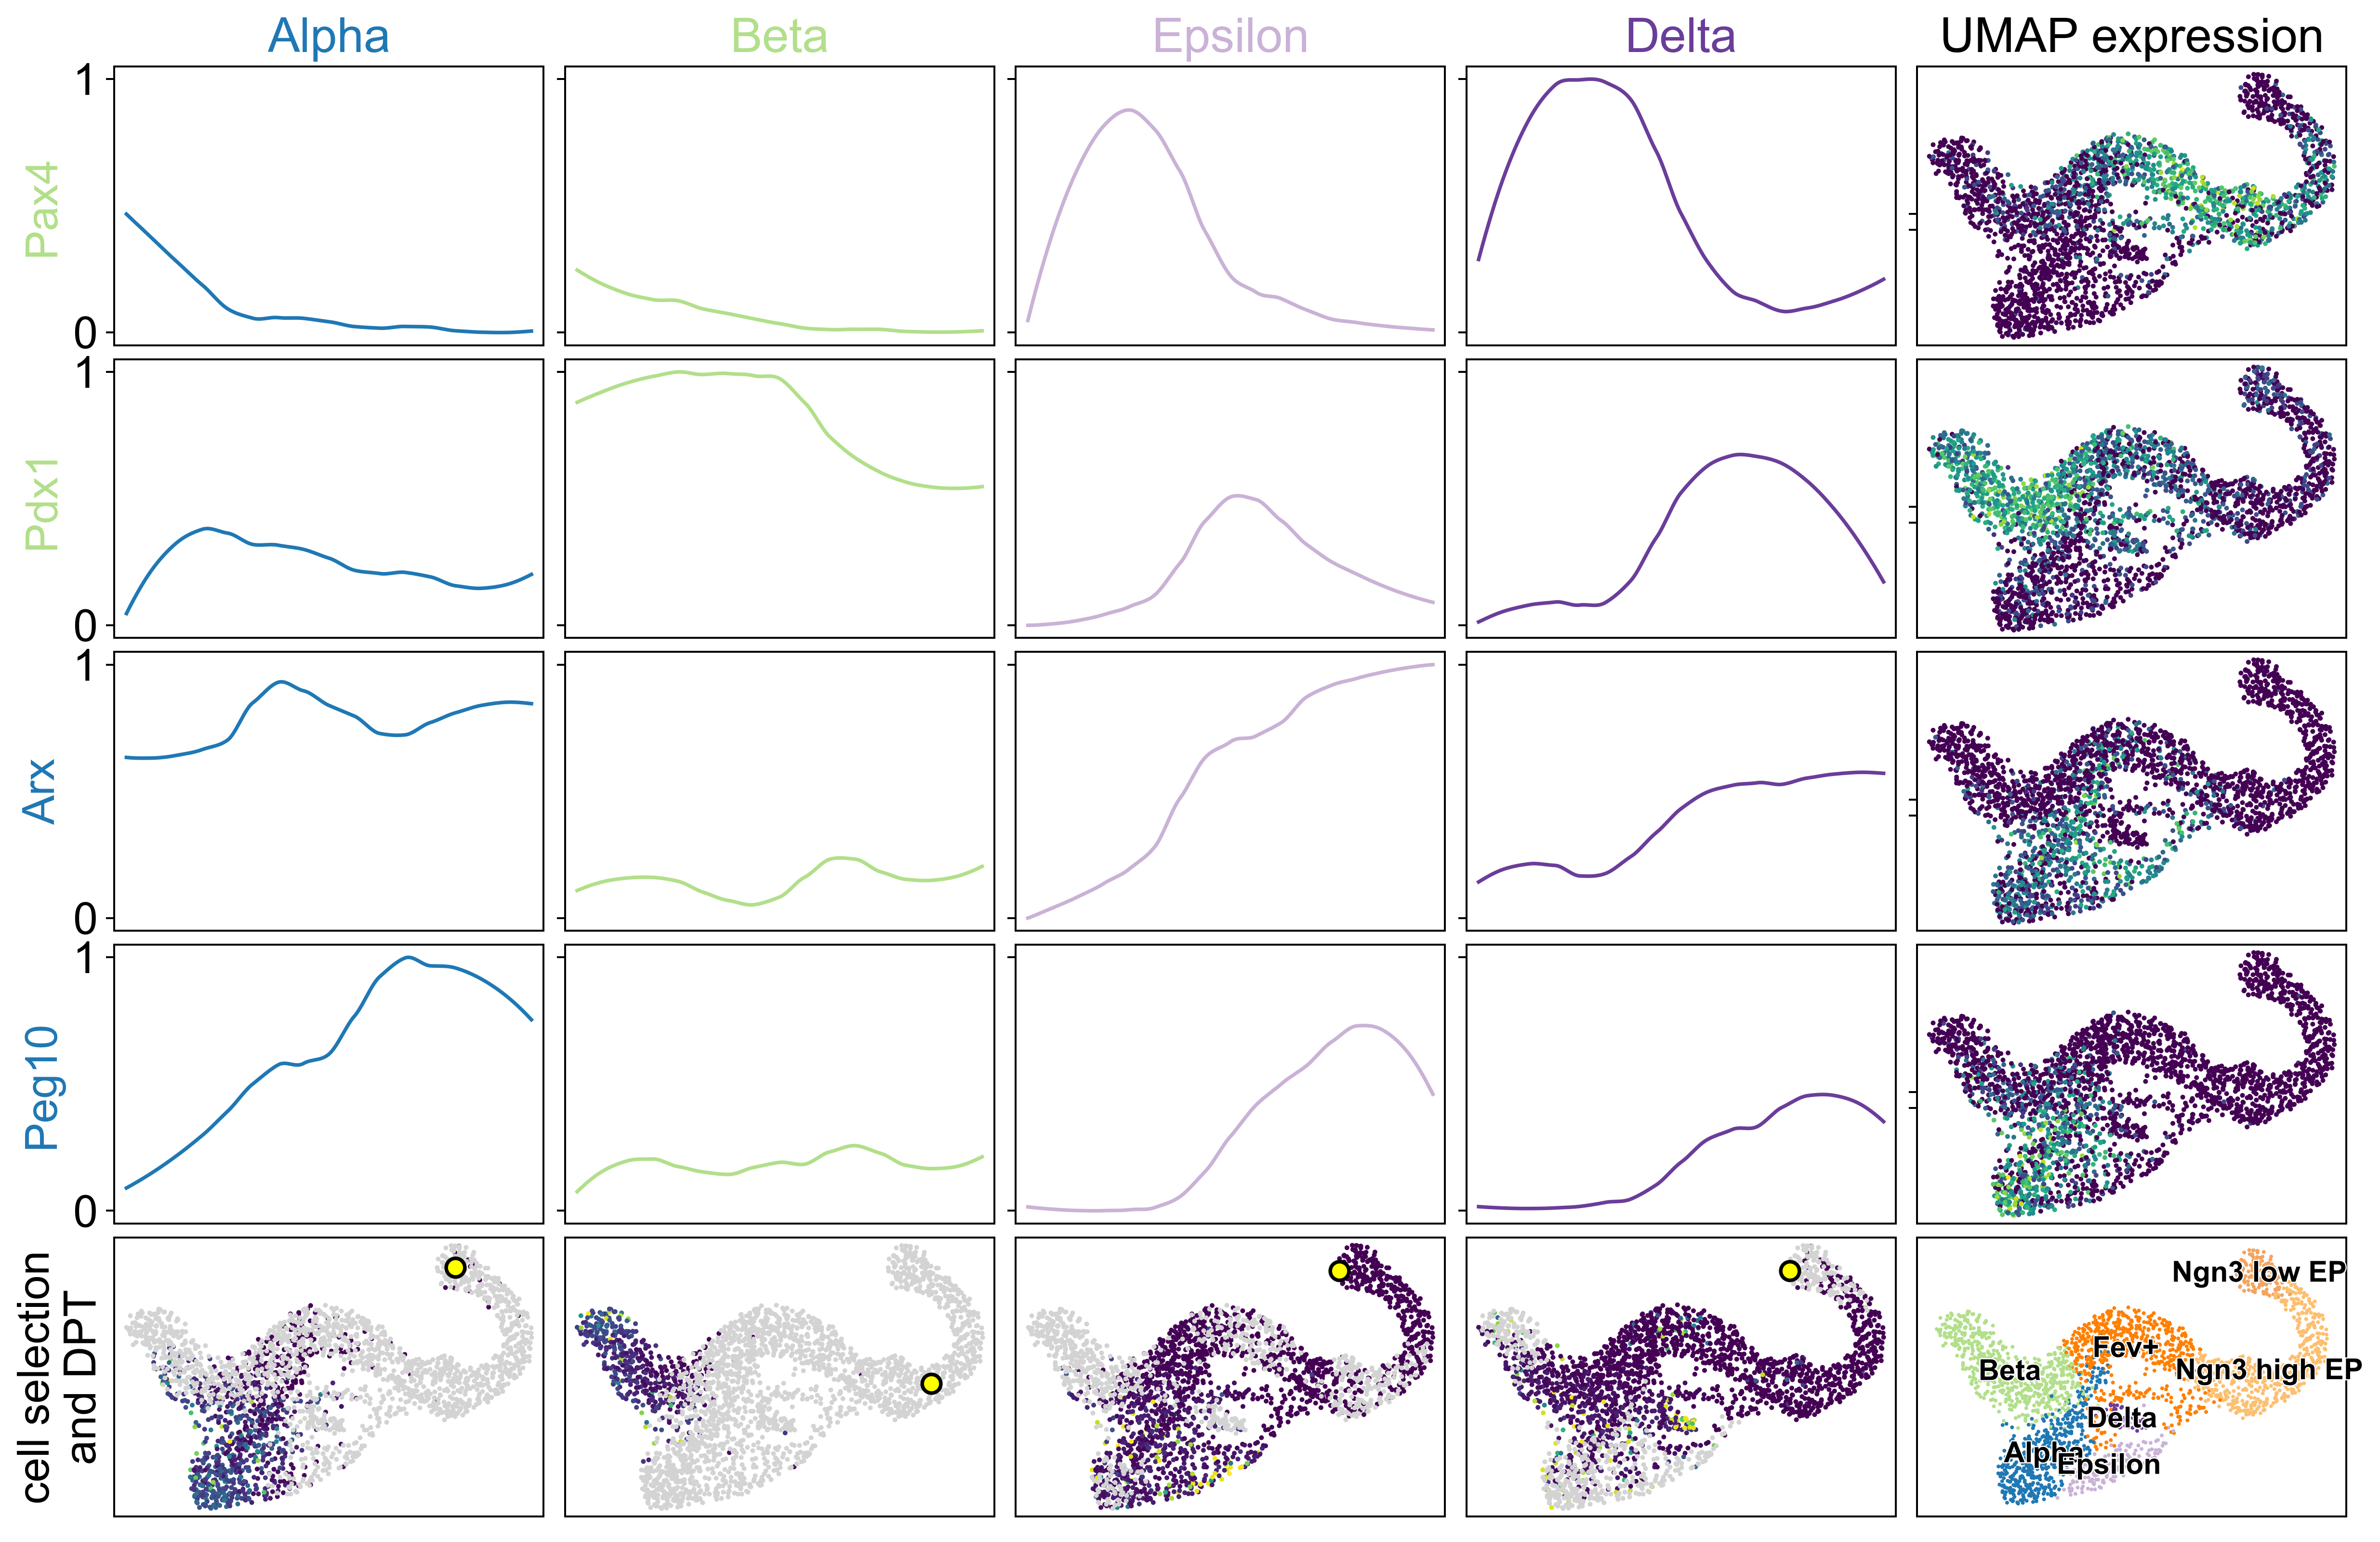

In [10]:
_ = plot(genes[:4], gene_colors[:4], lineages, fname=root_fig / "trends_genes_0-4.pdf" if save_figure else None)

## Plot the remaining 4 genes

<ipython-input-6-8f8323cbf238>:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


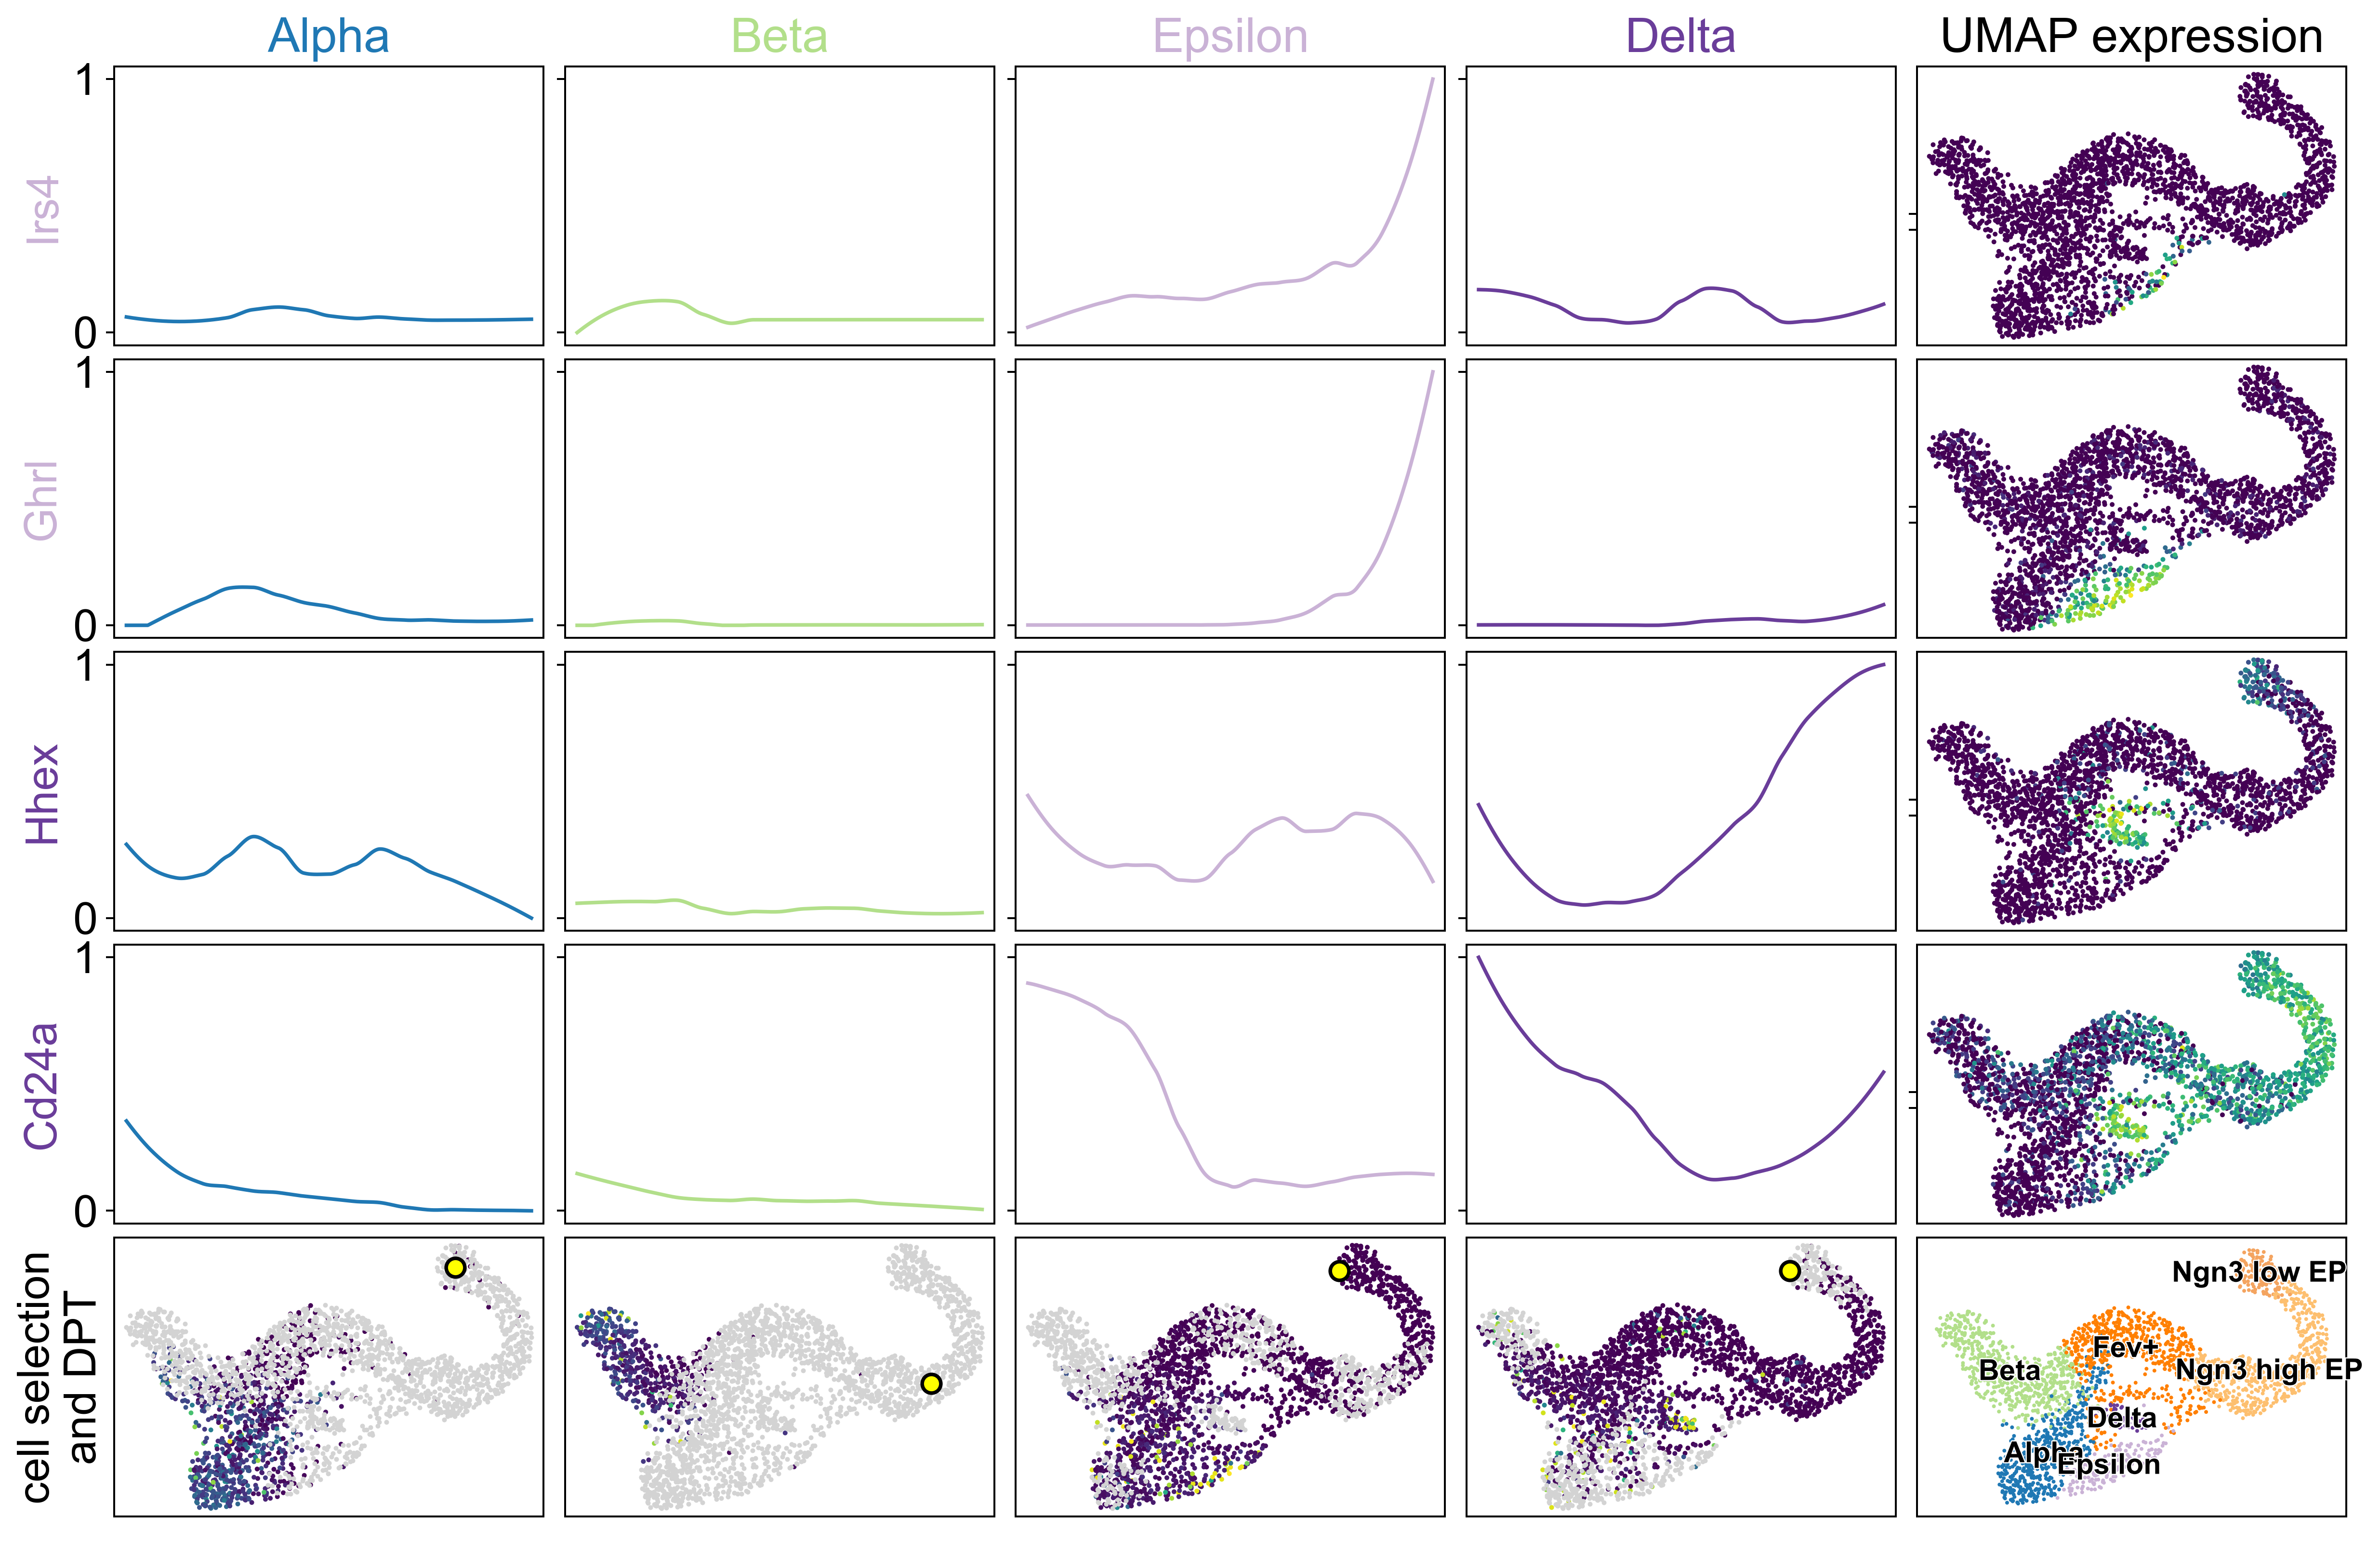

In [11]:
_ = plot(genes[4:], gene_colors[4:], lineages, fname=root_fig / "trends_genes_4-8.pdf" if save_figure else None)